Recapitulating the model: Receptor downregulation and desensitization enhance the information processing ability of signalling receptors

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te

The intial EGFR Model

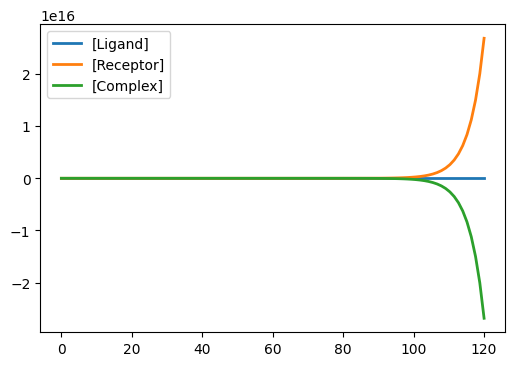

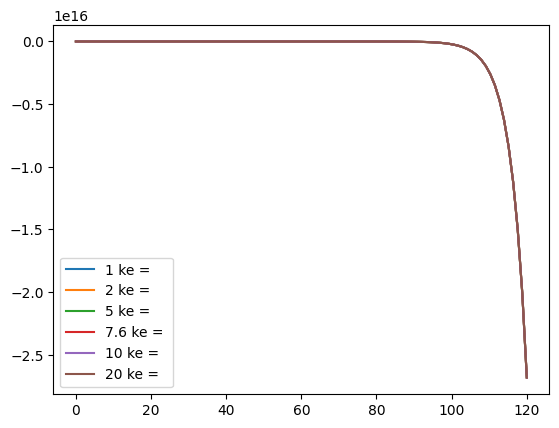

6


In [18]:
# seperate ligand and receptor entire EGFR model
shankaran_model_EGFR = te.loada("""

Ligand + Receptor -> Complex; Ligand*Receptor*kon

Complex -> ; Receptor*koff
-> Receptor ; kt*Rt

Complex -> Ligand; Complex*koff

Receptor = Rt/(V*Nav)
Complex = 0

kon = 0.097
koff = 0.24
Kd = koff/kon
kt = 0.02
ke = 0.15
Rt = 2*10^5

Vr = kt*Rt 
Nav = 6.022*10^23
V = 4*10^-10

at (time > 1): Ligand = 0.01*Kd
""")
shankaran_model_EGFR.reset()
m = shankaran_model_EGFR.simulate(0, 120, 100)
shankaran_model_EGFR.plot()

# change a species value to recreate the graph
shankaran_model_EGFR.resetAll()
count = 0
for i in [1,2,5,7.6,10,20]: 
    shankaran_model_EGFR.resetToOrigin()
    shankaran_model_EGFR.ke = 0.15*i
    result = shankaran_model_EGFR.simulate(0, 120, 100,['time','Complex'])
    plt.plot(result[:,0],result[:,1], label = '%s ke = '%i) 
    count += 1

plt.legend()
plt.show()
print(count)

Manipulating the EGFR model 

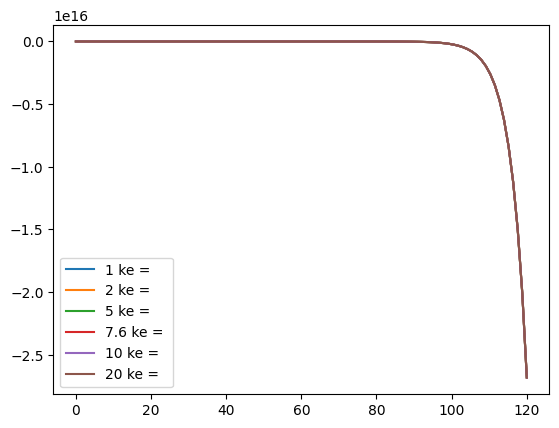

6


In [19]:
shankaran_model_EGFR.resetAll()
count = 0
for i in [1,2,5,7.6,10,20]: 
    shankaran_model_EGFR.resetToOrigin()
    shankaran_model_EGFR.ke = 0.15*i
    result = shankaran_model_EGFR.simulate(0, 120, 100,['time','Complex'])
    plt.plot(result[:,0],result[:,1], label = '%s ke = '%i) 
    count += 1

plt.legend()
plt.show()
print(count)

The GPCR Model

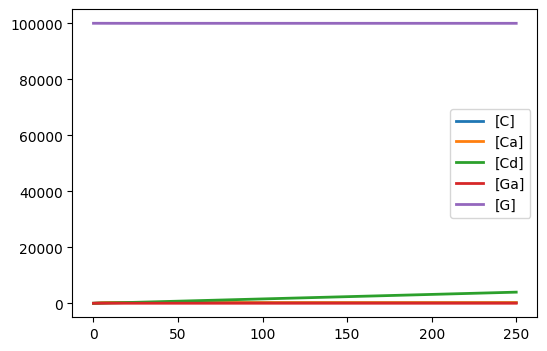

13.58888350238444
Kds =  0.0006500000000000001
13.476644155475725
Kds =  0.006500000000000001
12.448697870576472
Kds =  0.065
7.072370425255282
Kds =  0.65
1.3659884732389977
Kds =  6.5


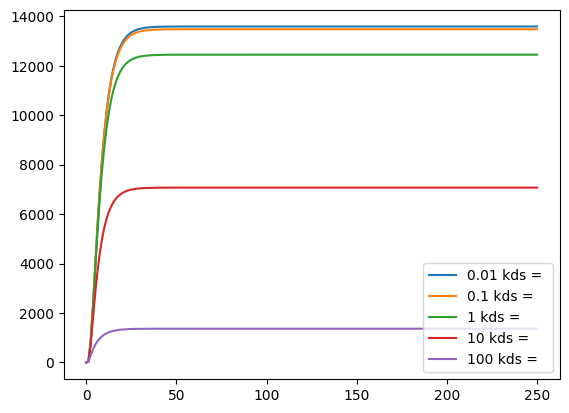

In [20]:
# seperate ligand and receptor GPCR
shankaran_model_GPCR = te.loada(""" 
$L + $R -> C; L*R*kon
C -> R; C*koff
C -> L; koff*C

C -> Ca; C*kfr
Ca -> C; Ca*krr

Ca -> Cd; Ca*kds

Ga -> G; Ga*ki
G -> Ga; G*ka
Ca + G -> Ga; ka*G*Ca

R = RT
G = GT
C = 0
Ca = 0
Cd =0
Ga = 0

kon = 8.4*10^7
koff = 0.37
Kd = koff/kon
kfr = 10
krr = 10
kds = 0.065
ka = 10^-7
ki = 2*10^-1

Nav = 6.022*10^23
V = 4*10^-10
RT = (5.5*10^4)
GT = (1*10^5)

at (time > 1): $L = 0.01*Kd
""")
shankaran_model_GPCR.resetToOrigin()
GPCR_model = shankaran_model_GPCR.simulate(0,250,100)
shankaran_model_GPCR.plot()

shankaran_model_GPCR.resetAll()
for i in [10**-2, 10**-1, 10**0, 10**1, 10**2]:
    shankaran_model_GPCR.resetToOrigin()
    shankaran_model_GPCR.kds = 0.065*i
    result = shankaran_model_GPCR.simulate(0, 250, 200,['time','Ga'])
    print(max(result[:,1]))
    print("Kds = ", shankaran_model_GPCR.kds)
    plt.plot(result[:,0],result[:,1]*1000, label = '%s kds = ' %i)

plt.legend()
plt.show()